# Modeling and Evaluation

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Image-Detector/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Image-Detector'

### Set Inputs

In [5]:
my_data_dir = 'inputs/datasets/raw/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set Outputs

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


### Set Labels

In [7]:
labels = os.listdir(train_path)
print( f"Project Labels: {labels}")

Project Labels: ['healthy', 'powdery_mildew']


### Set Image Shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

## Review number of images in sets

From the code below we get a nice visualization of the spread and quantity of images available to us in our data set.
We have a healthy ammount to train a model for our needs, but will still need to randomize these images a bit more to properly train the AI later on.

/tmp/ipykernel_1676/2172016582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_freq = df_freq.append(
/tmp/ipykernel_1676/2172016582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_freq = df_freq.append(
/tmp/ipykernel_1676/2172016582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_freq = df_freq.append(
/tmp/ipykernel_1676/2172016582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_freq = df_freq.append(
/tmp/ipykernel_1676/2172016582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_freq = df_freq.append(
/tmp/

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




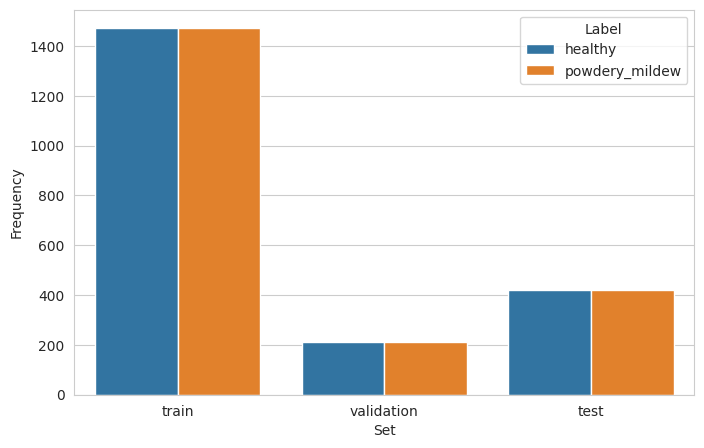

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image Augmentation

This function generates batches of image data with real-time data augmentation.

In this project, we are artificially creating more training images with a combination of
multiple processes like 
* a random rotation of 20 degrees
* shifting the width of images by 0.10 ratio of the image
* shifting the height of the images by 0.10 ratio of the images 
* shearing the image by 0.1
* zooming the image by 10 percent
* flipping the image horizontally and vertically
* filling the broken pixels of the images with the nearest pixel value
* and standardizing the image pixels between 0 to 255 pixels.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.10,
                                        height_shift_range=0.10,
                                        shear_range=0.1,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest',
                                        rescale=1./255
                                        )

2023-01-09 14:25:54.517612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We will apply augmented_image_data which we have initialized over the training, validation and testing sets
using flow_from_directory function to fetch images directly from the training folder.

We transform each image in width and height of average image_shape variable, Standard RGB
mode, batch_size of 20 images, binary class mode as we have two classes
of cell images, and we’ll also randomly shuffle the images.

In [11]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True
                                                    )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

We are also fetching images from the validation and test folders and
using the same function flow_from_directory on them but only for the image standardizing.

We are also only standardizing image pixels between 0 to 255 pixels using ImageDataGenerator for these two sets because  
we first need to build up our data set with large numbers of images of different scenarios so that we can train
our model which we will get from the training sets.

We’ll then use the Test and Validation datasets to simply test if our model is working.

In [12]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [13]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                target_size=image_shape[:2],
                                                                color_mode='rgb',
                                                                batch_size=batch_size,
                                                                class_mode='binary',
                                                                shuffle=False
                                                                )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Let's take a look at how these changes have effected some of the images in the train set.

(20, 256, 256, 3)


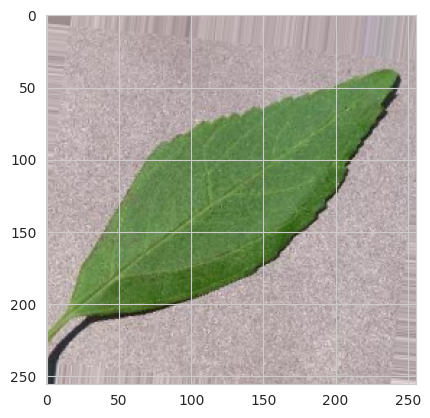

(20, 256, 256, 3)


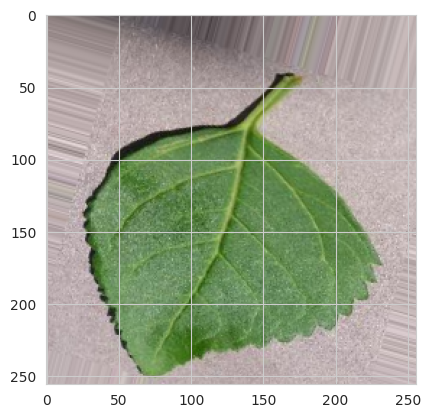

(20, 256, 256, 3)


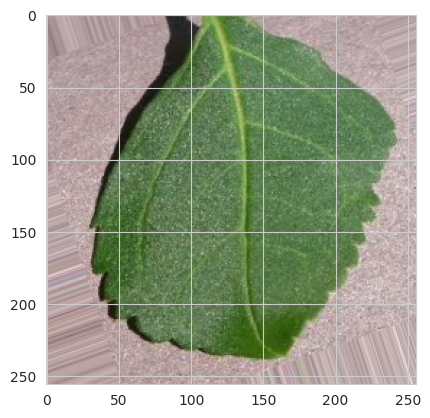

In [14]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

And for the validation and test images
we see the images are not rotated or sheared but only the pixels have
been standardized between 0 to 255 pixels. 

So now, the images are augmented and
are ready to be used for developing and training a CNN model.

(20, 256, 256, 3)


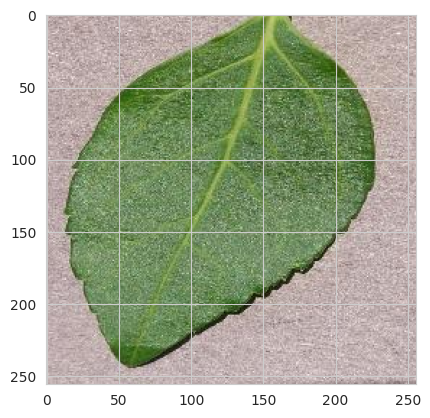

(20, 256, 256, 3)


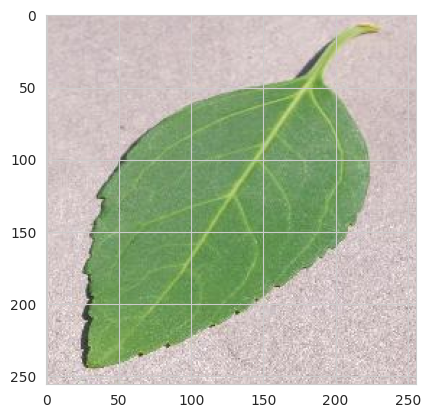

(20, 256, 256, 3)


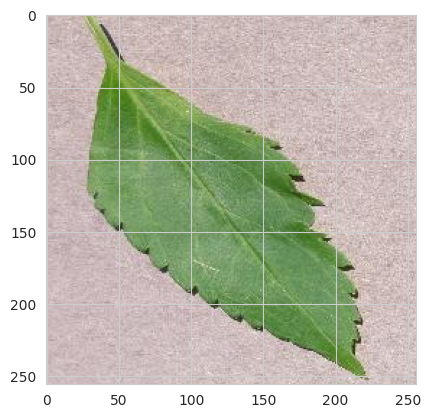

(20, 256, 256, 3)


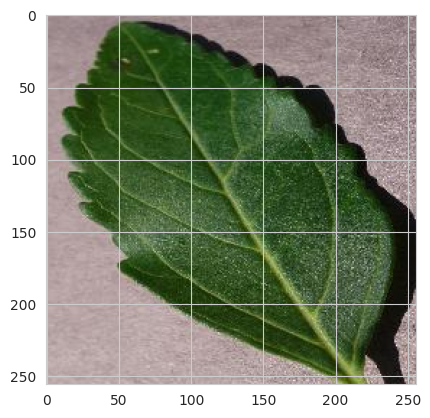

(20, 256, 256, 3)


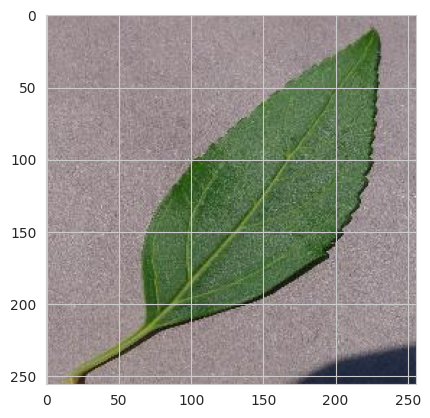

(20, 256, 256, 3)


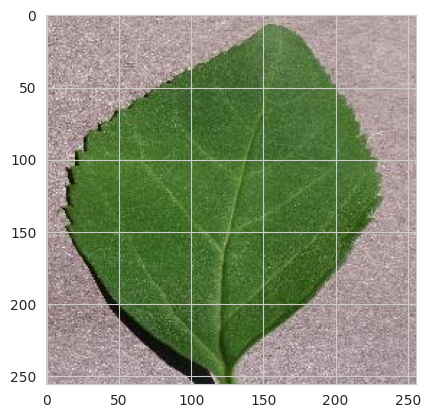

In [15]:
# Plot augmented validation and test images

for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

Save the indices of both classes to a pkl file.

In [16]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

## Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

This model has 5 layers: Conv2D, MaxPooling2D, Flatten,
Dense, and Dropout.  Each is used for its own specific reasons.

Convolution layers are used to select the dominant pixel value
from the non-dominant pixels in images using filters whereas the max-pooling layers reduce
the size of image by extracting only the dominant pixels within the pool size.  
This reduced image
only contains the dominant feature of the image.  The combination of these two layers removes
the nonessential part of the image and reduces complexity, therefore providing more accuracy.  
Here, in our model, we have used filters of a 3 by 3 matrix and their numbers are varied from
32 to 64, the pool size for the max-pooling layer is a 2 by 2 matrix.  
The input image shape in the
first convolution layer is served as the average image shape from the data visualization notebook.

As well as this, the flatten layer is used to flatten the matrix into a vector,
which means a single list of all values, and to
feed it into a dense layer.  
The dense layer then does the mathematical operation
and gives the output.  
In our model, we have used 128 nodes in one of our Dense layers,
and 1 node in the output dense layer, because we want single output at a time using the sigmoid
activation function.  
This output activation function defines the probabilistic result.

Finally, the Dropout layer is used in this network to drop 50 percent of the nodes
to avoid overfitting the model.
We use a combination of all these layers to develop a convolution neural network,
which we will use in the final prediction tasks.
The activation function in the output layer is sigmoid. The loss, optimizer,
and metrics used in the model compiler are binary cross-entropy, adam, and accuracy respectively.
These three hyperparameters along with the activation function of the output layer
which control the classification and regression problems.

In [18]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [19]:
create_tf_model().summary()

2023-01-09 14:34:35.812923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

Next, To fit the model over-training data we use the fit function.
We are also using early stopping to stop the model training in the situation of
overfitting or underfitting of the model.

This function triggers the learning process and iterates over the number of epochs
passed in the function. Here, we have used 25 epochs to train the model.   
The validation data is used to find out the performance of the model while training and
callbacks function to stop the model training in case of overfitting or underfitting of the model.  
The verbose value controls the visualization of learning progress. Setting it to 0 hides the progress bar, 1 keeps its default and 2 will reduce the information to 1 line per epoch.

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=2
          )

Epoch 1/25
147/147 - 161s - loss: 0.2262 - accuracy: 0.8950 - val_loss: 0.0360 - val_accuracy: 0.9952 - 161s/epoch - 1s/step
Epoch 2/25
147/147 - 164s - loss: 0.0603 - accuracy: 0.9829 - val_loss: 0.0166 - val_accuracy: 0.9929 - 164s/epoch - 1s/step
Epoch 3/25
147/147 - 171s - loss: 0.0572 - accuracy: 0.9836 - val_loss: 0.0183 - val_accuracy: 0.9929 - 171s/epoch - 1s/step
Epoch 4/25
147/147 - 189s - loss: 0.0204 - accuracy: 0.9932 - val_loss: 0.0078 - val_accuracy: 0.9976 - 189s/epoch - 1s/step
Epoch 5/25
147/147 - 164s - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0132 - val_accuracy: 0.9952 - 164s/epoch - 1s/step
Epoch 6/25
147/147 - 187s - loss: 0.0181 - accuracy: 0.9945 - val_loss: 0.0096 - val_accuracy: 0.9952 - 187s/epoch - 1s/step
Epoch 7/25
147/147 - 225s - loss: 0.1405 - accuracy: 0.9542 - val_loss: 0.0145 - val_accuracy: 0.9952 - 225s/epoch - 2s/step


And save the model.

In [22]:
model.save('outputs/v1/mildew_detector.h5')

---

## Evaluating Model Performance

### Model Learning Curve

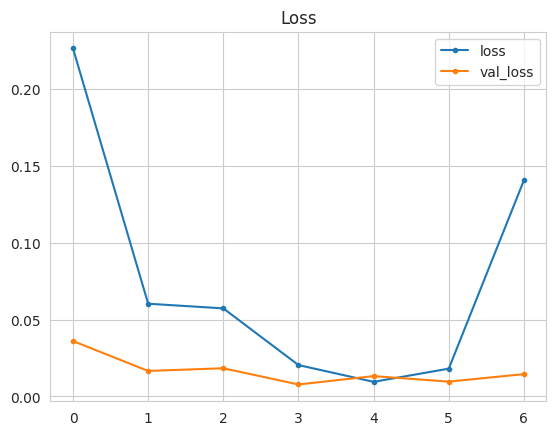

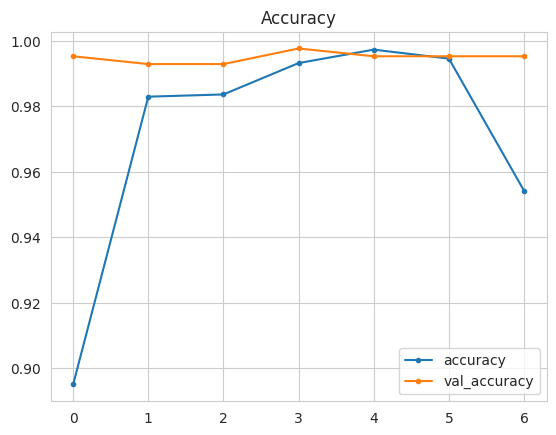

In [23]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

In [24]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector.h5')

evaluation = model.evaluate(test_set)

43/43 [==============================] - 19s 441ms/step - loss: 0.0112 - accuracy: 0.9953
